<a href="https://colab.research.google.com/github/yehezkielgunawan/thesis-risk-classification/blob/main/RF_Classification_Indo_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Load the new dataset for sentiment classification
new_data = pd.read_excel('/content/gdrive/My Drive/Tesis/Compiled Classification Dataset.xlsx')
new_data.head(5)
sentences = new_data['content'].tolist()

In [4]:
import torch
from transformers import AutoTokenizer, AutoModel

# Load IndoBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")

# Load IndoBERT model
model = AutoModel.from_pretrained("indolem/indobert-base-uncased")

# Convert the sentences into input features
encoded_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

# Perform word embedding using IndoBERT model
with torch.no_grad():
    outputs = model(**encoded_inputs)
    embeddings = outputs.last_hidden_state

# Convert the embeddings to numpy array
embeddings = embeddings.numpy()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [5]:
new_data.head(5)

# Check the label distributions
priority_score_distribution = new_data['priority_score'].value_counts()
problem_domain_distribution = new_data['problem_domain'].value_counts()

print("Label priority_score Distribution:")
print(priority_score_distribution)

print("Label problem_domain Distribution:")
print(problem_domain_distribution)

Label priority_score Distribution:
3    277
2    275
1    148
Name: priority_score, dtype: int64
Label problem_domain Distribution:
0    570
1    130
Name: problem_domain, dtype: int64


In [6]:
# Assuming the labels for the new dataset are stored in two columns: 'label1' and 'label2'
priority_score = new_data['priority_score']
problem_domain = new_data['problem_domain']

# Reshape the embeddings array
num_samples = len(embeddings)
num_features = embeddings.shape[1] * embeddings.shape[2]
reshaped_embeddings = embeddings.reshape(num_samples, num_features)

# Split the reshaped embeddings into training and testing sets for label 1
X_train1, X_test1, y_train1, y_test1 = train_test_split(reshaped_embeddings, priority_score, test_size=0.3, random_state=42)

# Split the reshaped embeddings into training and testing sets for label 2
X_train2, X_test2, y_train2, y_test2 = train_test_split(reshaped_embeddings, problem_domain, test_size=0.3, random_state=42)


In [7]:
# Define the parameter grid for Grid Search for priority_score
param_grid1 = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 12],
    'min_samples_split': [5, 7, 10]
}

# Define the parameter grid for Grid Search for problem_domain
param_grid2 = {
    'n_estimators': [25, 75, 125],
    'max_depth': [None, 5, 12],
    'min_samples_split': [2, 5, 10]
}

# Initialize the Random Forest classifiers
rf_classifier1 = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_classifier2 = RandomForestClassifier(class_weight="balanced", random_state=42)

# Perform Grid Search to find the best hyperparameters for priority_score
grid_search1 = GridSearchCV(estimator=rf_classifier1, param_grid=param_grid1, cv=5)
grid_search1.fit(X_train1, y_train1)

# Perform Grid Search to find the best hyperparameters for problem_domain
grid_search2 = GridSearchCV(estimator=rf_classifier2, param_grid=param_grid2, cv=5)
grid_search2.fit(X_train2, y_train2)

# Get the best classifiers with the optimal hyperparameters
best_classifier1 = grid_search1.best_estimator_
best_classifier2 = grid_search2.best_estimator_

# Evaluate the best classifiers on the test sets for priority_score
y_pred1 = best_classifier1.predict(X_test1)
classification_rep1 = classification_report(y_test1, y_pred1)

# Evaluate the best classifiers on the test sets for problem_domain
y_pred2 = best_classifier2.predict(X_test2)
classification_rep2 = classification_report(y_test2, y_pred2)

print("Best Hyperparameters for priority_score:", grid_search1.best_params_)
print("Classification Report for priority_score:")
print(classification_rep1)

print("Best Hyperparameters for problem_domain:", grid_search2.best_params_)
print("Classification Report for problem_domain:")
print(classification_rep2)

Best Hyperparameters for priority_score: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Classification Report for priority_score:
              precision    recall  f1-score   support

           1       0.57      0.10      0.17        39
           2       0.42      0.65      0.51        80
           3       0.53      0.46      0.49        91

    accuracy                           0.47       210
   macro avg       0.51      0.40      0.39       210
weighted avg       0.49      0.47      0.44       210

Best Hyperparameters for problem_domain: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 25}
Classification Report for problem_domain:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90       172
           1       0.60      0.08      0.14        38

    accuracy                           0.82       210
   macro avg       0.71      0.53      0.52       210
weighted avg       0.79      0.82      0.76       210


In [8]:
# Function to plot confusion matrix
def plot_confusion_matrix_3x3(cm, title):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues', xticklabels=[1,2,3], yticklabels=[1,2,3])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def plot_confusion_matrix_2x2(cm, title):
    plt.figure(figsize=(2, 2))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

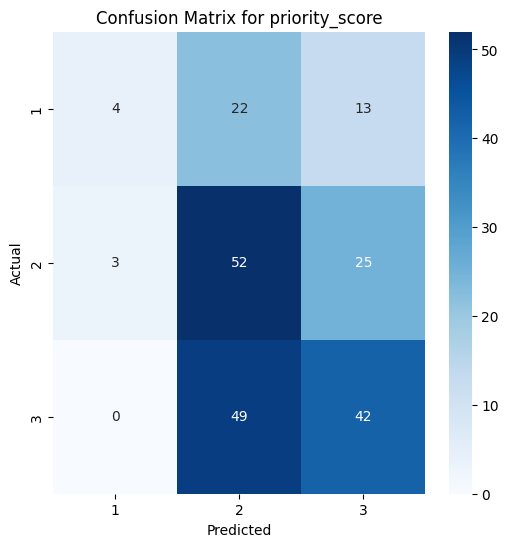

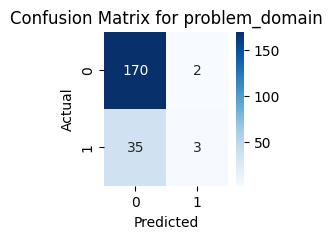

In [9]:
# Calculate confusion matrix for Label 1
cm1 = confusion_matrix(y_test1, y_pred1)

# Plot confusion matrix for Label 1
plot_confusion_matrix_3x3(cm1, title="Confusion Matrix for priority_score")

# Calculate confusion matrix for Label 2
cm2 = confusion_matrix(y_test2, y_pred2)

# Plot confusion matrix for Label 2
plot_confusion_matrix_2x2(cm2, title="Confusion Matrix for problem_domain")

In [10]:
# ... (rest of the code remains the same)

# Get the top words for each label in priority_score
top_words_by_label1 = {}
for label_idx, label in enumerate(set(priority_score)):
    # Filter the test data for the current label
    mask = y_test1 == label
    X_test1_label = X_test1[mask]

    # Get the predicted probabilities for the current label
    y_probs_label = best_classifier1.predict_proba(X_test1_label)

    # Get the importance scores for each word in the sequences
    importance_scores = np.max(y_probs_label, axis=1)

    # Sort the sequences based on importance scores
    sorted_indices = np.argsort(importance_scores)[::-1]

    # Get the corresponding words from the tokenizer (excluding padding tokens and special tokens)
    top_words = [tokenizer.decode(encoded_inputs["input_ids"][idx][encoded_inputs["attention_mask"][idx] == 1][1:-1])
                 for idx in sorted_indices[:3]]

    # Save the top words for the current label
    top_words_by_label1[label] = top_words

# Get the top words for each label in problem_domain
top_words_by_label2 = {}
for label_idx, label in enumerate(set(problem_domain)):
    # Filter the test data for the current label
    mask = y_test2 == label
    X_test2_label = X_test2[mask]

    # Get the predicted probabilities for the current label
    y_probs_label = best_classifier2.predict_proba(X_test2_label)

    # Get the importance scores for each word in the sequences
    importance_scores = np.max(y_probs_label, axis=1)

    # Sort the sequences based on importance scores
    sorted_indices = np.argsort(importance_scores)[::-1]

    # Get the corresponding words from the tokenizer (excluding padding tokens and special tokens)
    top_words = [tokenizer.decode(encoded_inputs["input_ids"][idx][encoded_inputs["attention_mask"][idx] == 1][1:-1])
                 for idx in sorted_indices[:3]]

    # Save the top words for the current label
    top_words_by_label2[label] = top_words

# Print the top words for each label in priority_score
print("Top words for each label in priority_score:")
for label, top_words in top_words_by_label1.items():
    print(f"Label {label}: {top_words}")

# Print the top words for each label in problem_domain
print("Top words for each label in problem_domain:")
for label, top_words in top_words_by_label2.items():
    print(f"Label {label}: {top_words}")

# Top words for each label in priority_score
priority_score_table = {}
for label, top_words in top_words_by_label1.items():
    priority_score_table[label] = ', '.join(top_words)

priority_score_table = pd.DataFrame(priority_score_table, index=['Top Words']).transpose()
priority_score_table.index.name = 'Label'

Top words for each label in priority_score:
Label 1: ['sblmnya mau tanya, knp setelah booking. akun saya keluar sndiri ya dari aplikasi, giliran saya coba masuk lg malah terblokir. padahal sy blm checkin krna msh 6 hari lg. gimana tu?', 'pelayanan resepsionis bobobox pancoran sangat mengecewakan, padahal cwo tapi judes ngomongnya nyolot. buat hotel sebagus ini tolong cari karyawan yg ramah yg bisa melayani tamu dengan baik', 'tidak bisa cek in karna belum vaksin, oke gpp. tapi uang tidak bisa di refund, kebijakan yang buruk.']
Label 2: ['kenapa sekarang gabisa bayar pakai shopee pay ya kak', 'emang harus swab dlu', 'aplikasi buruk, pelayanan dibawah standar, terlihat kru bobobox suka melakukan pelecehan seksual apalagi setelah kasus viral di berita. tolong tingkatkan kualitas, bila tidak aplikasi bisa ditinggalkan konsumen secara membabi - buta']
Label 3: ['gangguan trus skrg app nya jd susah buat booking', 'ribet harus verif ktp dulu', 'dengan senang hati saya uninstal aplikasi ini, s

In [11]:
import joblib
# Export the best_classifier1 (priority_score model)
joblib.dump(best_classifier1, '/content/gdrive/My Drive/Tesis/best_classifier1.pkl')

# Export the best_classifier2 (problem_domain model)
joblib.dump(best_classifier2, '/content/gdrive/My Drive/Tesis/best_classifier2.pkl')

['/content/gdrive/My Drive/Tesis/best_classifier2.pkl']

In [12]:
# Custom string input
custom_input = "APlikasi Bobobox parah nih, sering nge-lag. Crash melulu, ini lg check-in jd gak bisa buka pods kan."

# Tokenize the custom input
encoded_input = tokenizer(custom_input, padding=True, truncation=True, return_tensors="pt")

# Perform word embedding using IndoBERT model
with torch.no_grad():
    outputs_custom = model(**encoded_input)
    embeddings_custom = outputs.last_hidden_state.numpy()

# Reshape the embeddings
num_samples = embeddings_custom.shape[0]
num_features = embeddings_custom.shape[1] * embeddings.shape[2]
reshaped_embeddings = embeddings_custom.reshape(num_samples, num_features)

# Load the trained Random Forest models
best_classifier1 = joblib.load('/content/gdrive/My Drive/Tesis/best_classifier1.pkl')
best_classifier2 = joblib.load('/content/gdrive/My Drive/Tesis/best_classifier2.pkl')

# Predict the priority_score for the custom input
custom_priority_score = best_classifier1.predict(reshaped_embeddings)

# Predict the problem_domain for the custom input
custom_problem_domain = best_classifier2.predict(reshaped_embeddings)

# Print the predicted priority_score and problem_domain
print("Input text: ", custom_input)
print("Predicted Priority Score:", custom_priority_score[0])
print("Predicted Problem Domain:", custom_problem_domain[0])

Input text:  APlikasi Bobobox parah nih, sering nge-lag. Crash melulu, ini lg check-in jd gak bisa buka pods kan.
Predicted Priority Score: 2
Predicted Problem Domain: 0
